In [2]:
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import numpy as np
import eli5 

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, RandomizedSearchCV, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
from scipy.stats import loguniform
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix
from eli5.sklearn import PermutationImportance
from sklearn.inspection import permutation_importance


CIP_data_no_drop = pd.read_csv("CIP_data_encode_prev_not_dropped.csv")
print(CIP_data_no_drop.columns)

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'CLINIC', 'YEAR',
       'GENDERSP', 'Susceptible', 'MSM', 'MSMW', 'MSW', 'Oth/Unk/Missing',
       'REGION', 'Midwest', 'Northeast', 'Southeast', 'Southwest', 'West',
       'PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION'],
      dtype='object')


In [6]:
######### Step 1: Hyperparameter tuning round 1 WITH OVERSAMPLING not "balanced" weights

model_rf = RandomForestClassifier(n_estimators = 100, min_samples_leaf=5, max_features = 'sqrt', random_state = 42)
oversample = RandomOverSampler(sampling_strategy = 0.5,random_state=42)

## tuning just on training data
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

## what if tuned in all data?
X_train = CIP_data_no_drop[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - CIP_data_no_drop['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train) ## need to resample even if I'm doing the entire dataset? Cos the model needs to be fit 

### parameters for search
cv = RepeatedStratifiedKFold(n_splits=10, random_state=1)
space = dict()
space['n_estimators'] = np.arange(1, 201, 10)
space['max_depth'] = np.arange(1, 200, 10)
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,2,4]


## find hyperparameters
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)
result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

#Best Hyperparameters:  {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 61}


Best Score: 0.8262273226904604
Best Hyperparameters: {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 61}


In [7]:
##### Step 2: FEATURE ENGINEERING
## get better results using oversampling, not balanced dataset
#Best Hyperparameters:  {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 61}

model_rf = RandomForestClassifier(n_estimators = 161, min_samples_split = 2, min_samples_leaf=1, max_features = 'sqrt', max_depth = 61, random_state = 42)


## Temporal split training data 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009,2010])]
X_train = train_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

model_fit = model_rf.fit(X_train, y_train)

#test data: 2009 - 2019 
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
X_test = test_data[['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

y_predict = model_rf.predict(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) ## why is this higher than when I remove features?

perm = PermutationImportance(model_fit, random_state=1).fit(X_test,y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ROC_AUC_rf: 0.6304857575324013


Weight,Feature
0.0263 ± 0.0018,PREV_CLINIC
0.0233 ± 0.0014,MSM
0.0054 ± 0.0025,MSW
0.0009 ± 0.0007,DELTA_REGION
0.0001 ± 0.0003,MSMW
0.0000 ± 0.0005,Southeast
-0.0006 ± 0.0003,Oth/Unk/Missing
-0.0014 ± 0.0005,Midwest
-0.0014 ± 0.0004,Northeast
-0.0017 ± 0.0004,West


In [8]:
feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','Prev. Region', 'Prev. Clinic','Change']

PI = permutation_importance(model_fit, X_test, y_test, n_repeats = 10, random_state = 42)
#feature_names = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC','DELTA_REGION']
for i in PI.importances_mean.argsort()[::-1]:
    if PI.importances_mean[i] - 2 * PI.importances_std[i] > -1:
            print(f"{feature_names[i]:<8}" #works cos they are in same order as the x columns
            f"{PI.importances_mean[i]:.3f}"
            f" +/- {PI.importances_std[i]:.3f}")

Prev. Clinic0.026 +/- 0.002
MSM     0.023 +/- 0.001
MSW     0.005 +/- 0.001
Change  0.001 +/- 0.001
MSMW    -0.000 +/- 0.000
Southeast-0.000 +/- 0.000
Midwest -0.000 +/- 0.001
Oth/Unk/Missing-0.001 +/- 0.000
Northeast-0.001 +/- 0.000
West    -0.001 +/- 0.001
Southwest-0.002 +/- 0.000
Prev. Region-0.003 +/- 0.001


([<matplotlib.axis.YTick at 0x17931a950>,
 [Text(0, 0, 'Prev. Clinic'),
  Text(0, 1, 'MSM'),
  Text(0, 2, 'MSW'),
  Text(0, 3, 'Change'),
  Text(0, 4, 'MSMW'),
  Text(0, 5, 'Southeast'),
  Text(0, 6, 'Midwest'),
  Text(0, 7, 'Oth/Unk/Missing'),
  Text(0, 8, 'Northeast'),
  Text(0, 9, 'West'),
  Text(0, 10, 'Southwest'),
  Text(0, 11, 'Prev. Region')])

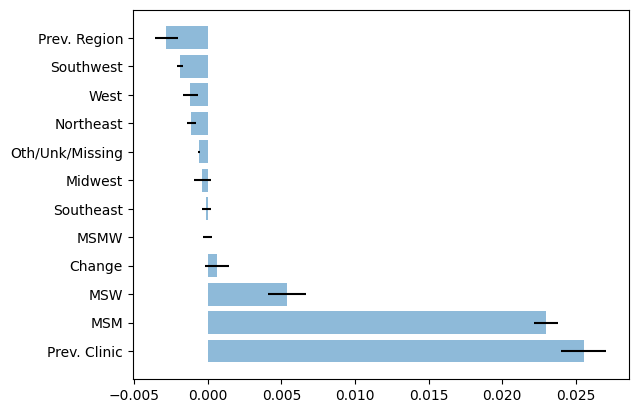

In [9]:
### graph feature engineering results 
feature_names = np.array(feature_names)
feature_names_by_importance = feature_names[PI.importances_mean.argsort()[::-1]]
mean_importance_by_importance = PI.importances_mean[PI.importances_mean.argsort()[::-1]]
std_importance_by_importance = PI.importances_std[PI.importances_mean.argsort()[::-1]]

plt.barh(y = range(mean_importance_by_importance.size), width =mean_importance_by_importance,
 xerr= std_importance_by_importance, alpha = 0.5)#c8b6ff") # xmin = min(feature_names_by_importance), xmax = max(feature_names_by_importance))
plt.yticks(range(feature_names_by_importance.size), feature_names_by_importance)

#plt.savefig('Graphs/Features_by_importance_post_hyperparameter_random_forest.png')

In [11]:
##### HYPERPARAMETER TUNING without  prev_region, southwest, west, northeast, other

model_rf = RandomForestClassifier(n_estimators = 161, min_samples_split = 2, min_samples_leaf=1, max_features = 'sqrt', max_depth = 61, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW',  'Southeast', 'Midwest','PREV_CLINIC', 'DELTA_REGION']

## what if tuned in all data?
X_train = CIP_data_no_drop[feature_names]
y_train = 1 - CIP_data_no_drop['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=1)

space = dict()
space['n_estimators'] = np.arange(1, 201, 10)
space['max_features'] = ['sqrt']
space['max_depth'] = np.arange(1, 200, 10)
space['min_samples_split'] = [2,5,10]
space['min_samples_leaf'] = [1,2,4]
search = RandomizedSearchCV(model_rf, space, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=1)

result = search.fit(X_train, y_train)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)
#Best Hyperparameters: {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 61}



Best Score: 0.8261784138261596
Best Hyperparameters: {'n_estimators': 161, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 61}


In [12]:
###### Specificity and sensitivity of model on entire dataset
###### Dropping 
model_rf = RandomForestClassifier(n_estimators = 161, min_samples_split = 2, min_samples_leaf=1, max_features = 'sqrt', max_depth = 61, random_state = 42)

#loop setup
threshold_seq = np.linspace(0,1,101)

feature_names = ['MSM','MSMW', 'MSW',  'Southeast', 'Midwest','PREV_CLINIC', 'DELTA_REGION']
#features = ['MSM','MSMW', 'MSW', 'Oth/Unk/Missing','Northeast', 'Southeast', 'Southwest', 'West', 'Midwest','PREV_REGION', 'PREV_CLINIC', 'DELTA_REGION']
#   train 
train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[feature_names]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[feature_names]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

 #1. Create model using all data and get the apparent sensitivity and specificty 

model_fit_train = model_rf.fit(X_train, y_train)

  #2. Test model on test data to get test specificity and sensitivity 
  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 
#dataframes
sensitivity_test_threshold = []
specificity_test_threshold = [] #no bootstrapping, no 95% CI 

for threshold in threshold_seq:
  #print(threshold)
 
 
  y_predict_test = np.where(y_predict_proba[:, 1] > threshold, 1, 0)

  tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict_test).ravel()

  sensitivity_test  = tp_test  / (tp_test   + fn_test )
  specificity_test   = tn_test / (tn_test + fp_test )
  
  # Save results
  sensitivity_test_threshold.append(sensitivity_test)
  specificity_test_threshold.append(specificity_test)

ROC_AUC_rf: 0.6234494912049182


In [13]:
#performance metrics on training set of 2000-2010 and test set of 2011-2019 without west and southeast and with tuned hyperparameters
model_rf = RandomForestClassifier(n_estimators = 151, min_samples_split = 10, min_samples_leaf=1, max_features = 'sqrt', max_depth = 11, random_state = 42)
feature_names = ['MSM','MSMW', 'MSW',  'Southeast', 'Midwest','PREV_CLINIC', 'DELTA_REGION']

train_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010])]
X_train = train_data[feature_names]
y_train = 1 - train_data['Susceptible']
X_train, y_train = oversample.fit_resample(X_train,y_train)

# test
test_data = CIP_data_no_drop.loc[CIP_data_no_drop['YEAR'].isin([2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

X_test = test_data[feature_names]
y_test = 1 - test_data['Susceptible']
X_test, y_test = oversample.fit_resample(X_test,y_test)

model_fit_train = model_rf.fit(X_train, y_train)

  
y_predict = model_fit_train.predict(X_test)
y_predict_proba = model_fit_train.predict_proba(X_test)

###ROC 
ROC_AUC_random_forest= metrics.roc_auc_score(y_test, y_predict)

print('ROC_AUC_rf:', ROC_AUC_random_forest) 

###F1 score

tn_test , fp_test , fn_test , tp_test  = confusion_matrix(y_true=y_test, y_pred=y_predict).ravel()

precision = tp_test/(tp_test + fp_test)
recall = tp_test/(tp_test + fn_test)
f1_score = 2/(1/precision + 1/recall)
print("F1_me: ", f1_score)
###

from sklearn.metrics import f1_score

print("F1", f1_score(y_test, y_predict))
print("F1 macro: ", f1_score(y_test, y_predict, average = "macro"))

### MCC score
from sklearn.metrics import matthews_corrcoef
import math

MCC_me = ((tp_test*tn_test) - (fp_test*fn_test))/math.sqrt((tp_test + fp_test)*(tp_test + fn_test)*(tn_test + fp_test)*(tn_test + fn_test))
print("MCC:", MCC_me)

print("MCC:", matthews_corrcoef(y_test, y_predict))


## specificity and sensitivity for threshold = 0.5 

sensitivity_test  = tp_test  / (tp_test   + fn_test )
specificity_test   = tn_test / (tn_test + fp_test )

print("Sensitivity: ", sensitivity_test)
print("Specificity: ", specificity_test)

ROC_AUC_rf: 0.629795662479621
F1_me:  0.5392344600555113
F1 0.5392344600555112
F1 macro:  0.6033026341065988
MCC: 0.24475702271710534
MCC: 0.24475702271710534
Sensitivity:  0.6782312188785451
Specificity:  0.5813601060806971
